<a href="https://colab.research.google.com/github/EdsilvaEps/Fall-Detector-ESP32/blob/main/Fall_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q requests bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0
!pip install -q kaggle pandas matplotlib
!pip install numpy
!apt-get -qq install xxd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 849.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import userdata
import torch
import kagglehub
import pandas as pd
import os, glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Login to Kaggle


In [ ]:
kg_token = userdata.get('KAGGLE')
kagglehub.login(kg_token)

## Load Dataset
Fall detection from smartphone accelerometer from Kaggle

In [ ]:
DATASET = "felliphnascimento/accelerometer-falling-detection"
#FILEPATH =


dataset_path = kagglehub.dataset_download(DATASET)

100%|██████████| 2.01M/2.01M [00:00<00:00, 21.1MB/s]

Extracting files...


In [ ]:
dataset_path += '/Dataset'
dataset_path

'/root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset'

## Check data

In [ ]:
falling_back_hand = dataset_path + '/falling_Back_Hand'
"""pattern = os.path.join(falling_back_hand, "**" ,'*.csv')
csv_files = glob.glob(pattern, recursive=True)
#csv_files
print(falling_back_hand)
print(csv_files)

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.head(10)"""

# check single event
falling_back_hand_event = falling_back_hand + '/falling_back_hand_3.csv'
df = pd.read_csv(falling_back_hand_event)
df.head(10)

,label,timestamp,x,y,z
0,falling_back_hand,0.000,-0.591,3.758,8.762
1,falling_back_hand,0.020,-0.587,3.641,8.905
2,falling_back_hand,0.040,-0.189,3.501,9.213
3,falling_back_hand,0.060,-0.097,3.332,9.453
4,falling_back_hand,0.080,-0.074,3.312,9.248
5,falling_back_hand,0.100,0.947,3.724,9.375
6,falling_back_hand,0.120,1.733,4.043,9.562
7,falling_back_hand,0.141,0.242,3.332,9.751
8,falling_back_hand,0.161,0.099,3.479,10.449
9,falling_back_hand,0.181,1.031,3.915,10.152


In [ ]:
# change original colum labels to more explainable titles
df = df.rename(columns={
    'x': 'roll',
    'y': 'pitch',
    'z': 'yaw'
})

# basic data checks
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      304 non-null    object 
 1   timestamp  304 non-null    float64
 2   roll       304 non-null    float64
 3   pitch      304 non-null    float64
 4   yaw        304 non-null    float64
dtypes: float64(4), object(1)
memory usage: 12.0+ KB


,label,timestamp,roll,pitch,yaw
count,304,304.000000,304.000000,304.000000,304.000000
unique,1,NaN,NaN,NaN,NaN
top,falling_back_hand,NaN,NaN,NaN,NaN
freq,304,NaN,NaN,NaN,NaN
mean,NaN,3.052467,2.429312,-1.285237,8.331431
std,NaN,1.771321,5.464182,2.580733,3.899010
min,NaN,0.000000,-3.804000,-11.101000,-13.879000
25%,NaN,1.526000,0.950750,-2.312000,8.882250
50%,NaN,3.052500,1.227000,-2.018000,9.337500
75%,NaN,4.579000,1.898500,-1.417000,9.592500


## Plotting the IMU orienation vs Time

In [ ]:
# unwrap angles to remove jump at ±180 or ±360 deg
for col in ["roll", "pitch", "yaw"]:
    df[col + "_unwrapped"] = np.rad2deg(np.unwrap(np.deg2rad(df[col].values)))

# Optional: light smoothing (moving average)
window = 5
for col in ["roll_unwrapped", "pitch_unwrapped", "yaw_unwrapped"]:
    df[col + "_sm"] = df[col].rolling(window, center=True, min_periods=1).mean()

df.head()

,label,timestamp,roll,pitch,yaw,roll_unwrapped,pitch_unwrapped,yaw_unwrapped,roll_unwrapped_sm,pitch_unwrapped_sm,yaw_unwrapped_sm
0,falling_back_hand,0.00,-0.591,3.758,8.762,-0.591,3.758,8.762,-4.556667e-01,3.633333,8.96000
1,falling_back_hand,0.02,-0.587,3.641,8.905,-0.587,3.641,8.905,-3.660000e-01,3.558000,9.08325
2,falling_back_hand,0.04,-0.189,3.501,9.213,-0.189,3.501,9.213,-3.076000e-01,3.508800,9.11620
3,falling_back_hand,0.06,-0.097,3.332,9.453,-0.097,3.332,9.453,2.220446e-17,3.502000,9.23880
4,falling_back_hand,0.08,-0.074,3.312,9.248,-0.074,3.312,9.248,4.640000e-01,3.582400,9.37020


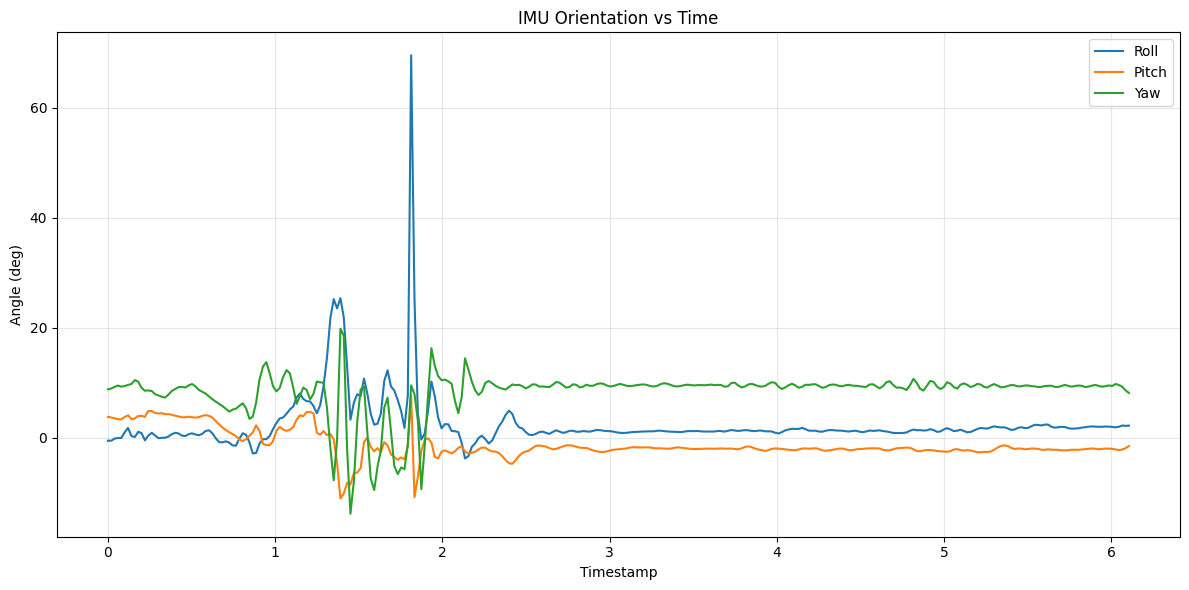

In [ ]:
# Plot
subtitle = ""
title = "IMU Orientation vs Time" + subtitle
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], df["roll"], label="Roll")
plt.plot(df["timestamp"], df["pitch"], label="Pitch")
plt.plot(df["timestamp"], df["yaw"], label="Yaw")
plt.xlabel("Timestamp")
plt.ylabel("Angle (deg)")
plt.title(title)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def plotgraph(path):
  _df = pd.read_csv(path)
  _df = _df.rename(columns={
    'x': 'roll',
    'y': 'pitch',
    'z': 'yaw'
  })

  title = "IMU Orientation vs Time - " + subtitle


  # Plot
  plt.figure(figsize=(12, 6))
  plt.plot(_df["timestamp"], _df["roll"], label="Roll")
  plt.plot(_df["timestamp"], _df["pitch"], label="Pitch")
  plt.plot(_df["timestamp"], _df["yaw"], label="Yaw")
  plt.xlabel("Timestamp")
  plt.ylabel("Angle (deg)")
  plt.title(title)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()


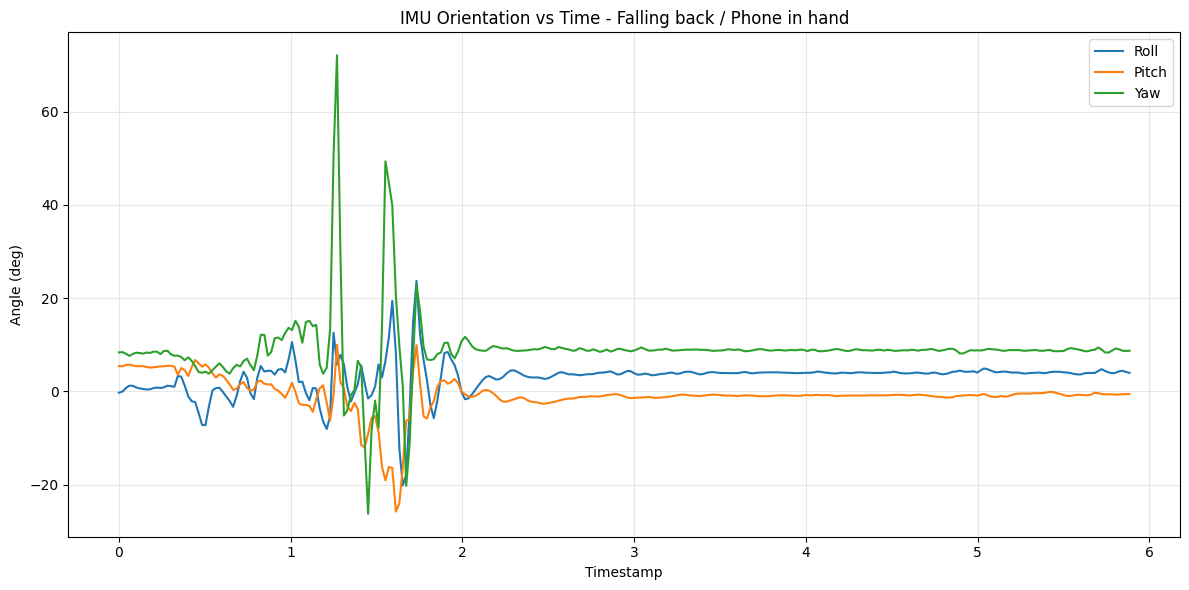

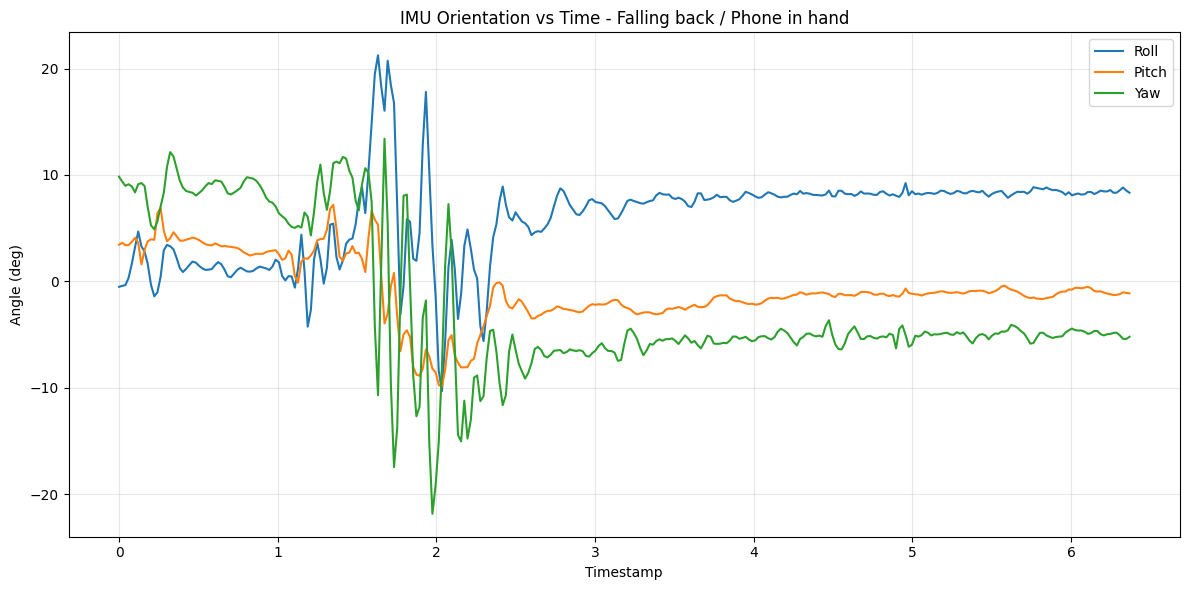

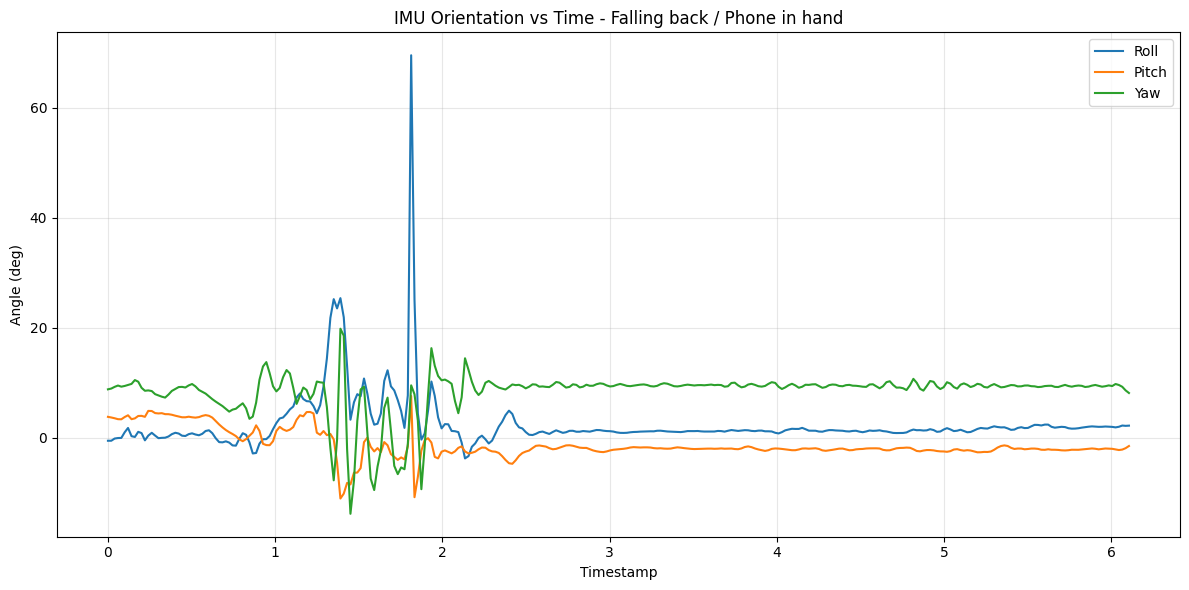

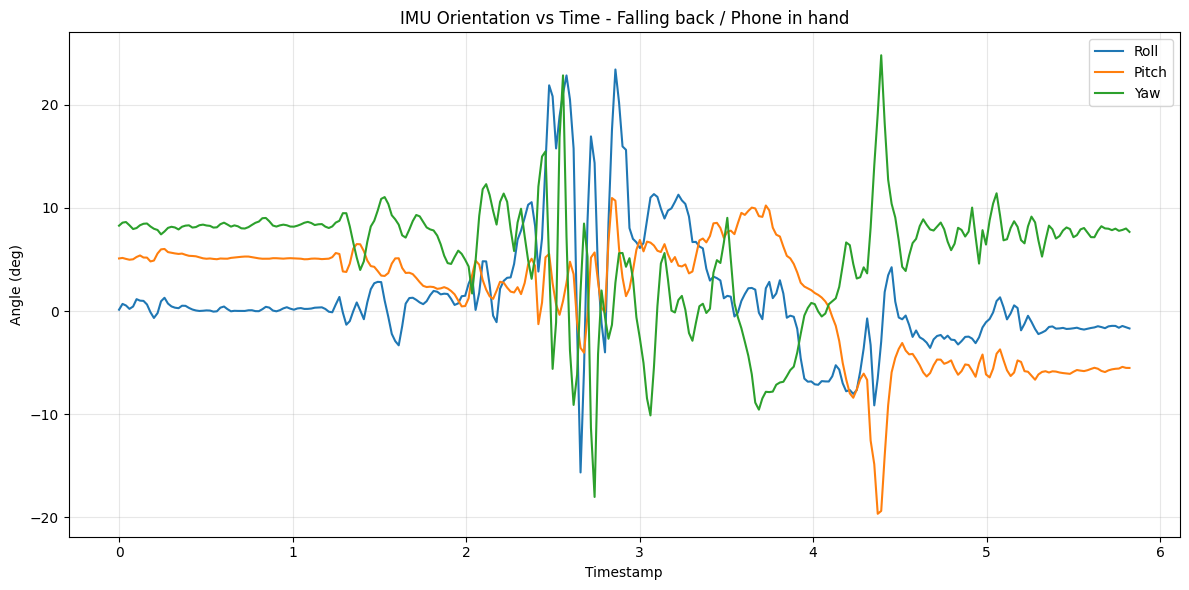

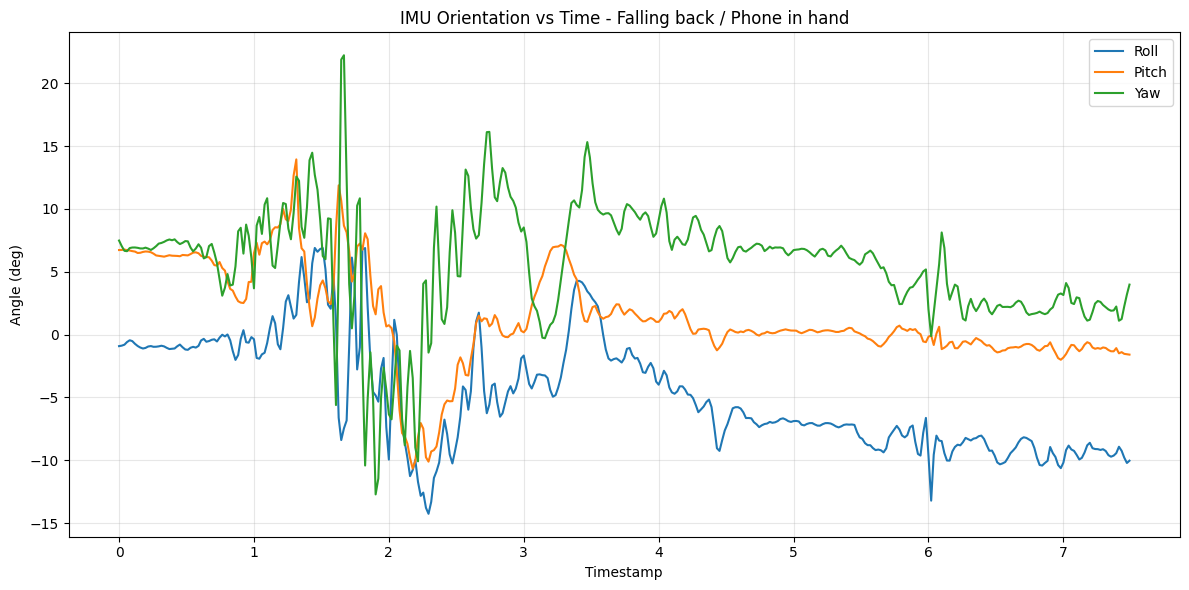

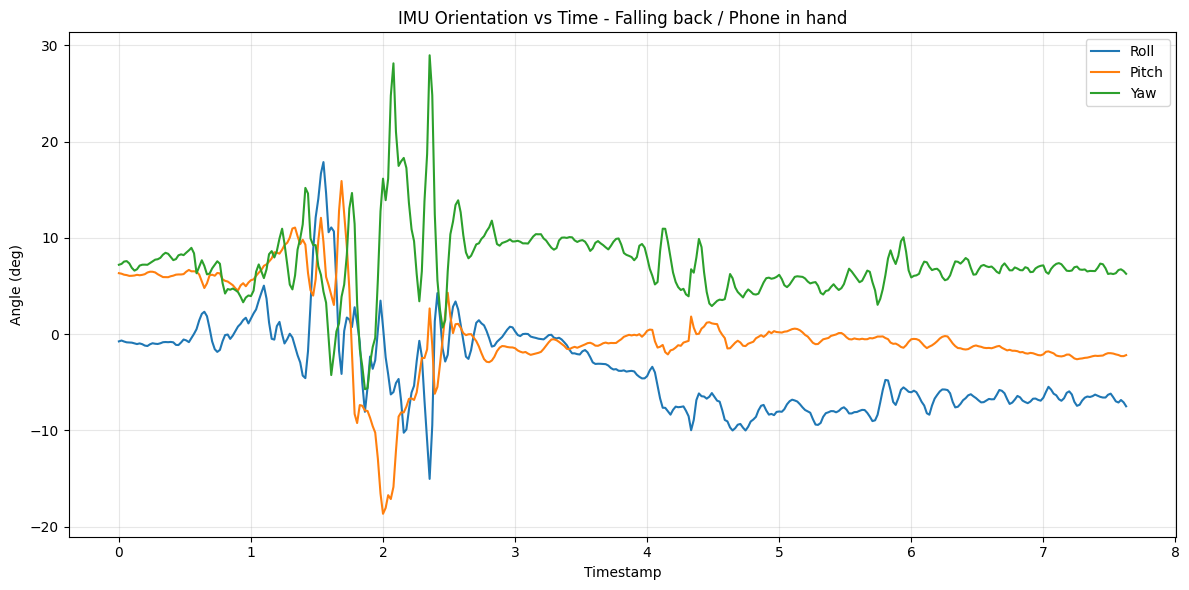

In [ ]:
# plotting falling back events - phone in hand
falling_back_hand_event_1 = falling_back_hand + '/falling_back_hand_1.csv'
falling_back_hand_event_2 = falling_back_hand + '/falling_back_hand_2.csv'
falling_back_hand_event_3 = falling_back_hand + '/falling_back_hand_3.csv'
falling_back_hand_event_4 = falling_back_hand + '/falling_back_hand_4.csv'
falling_back_hand_event_5 = falling_back_hand + '/falling_back_hand_5.csv'
falling_back_hand_event_6 = falling_back_hand + '/falling_back_hand_6.csv'
subtitle = "Falling back / Phone in hand"

plotgraph(falling_back_hand_event_1)
plotgraph(falling_back_hand_event_2)
plotgraph(falling_back_hand_event_3)
plotgraph(falling_back_hand_event_4)
plotgraph(falling_back_hand_event_5)
plotgraph(falling_back_hand_event_6)

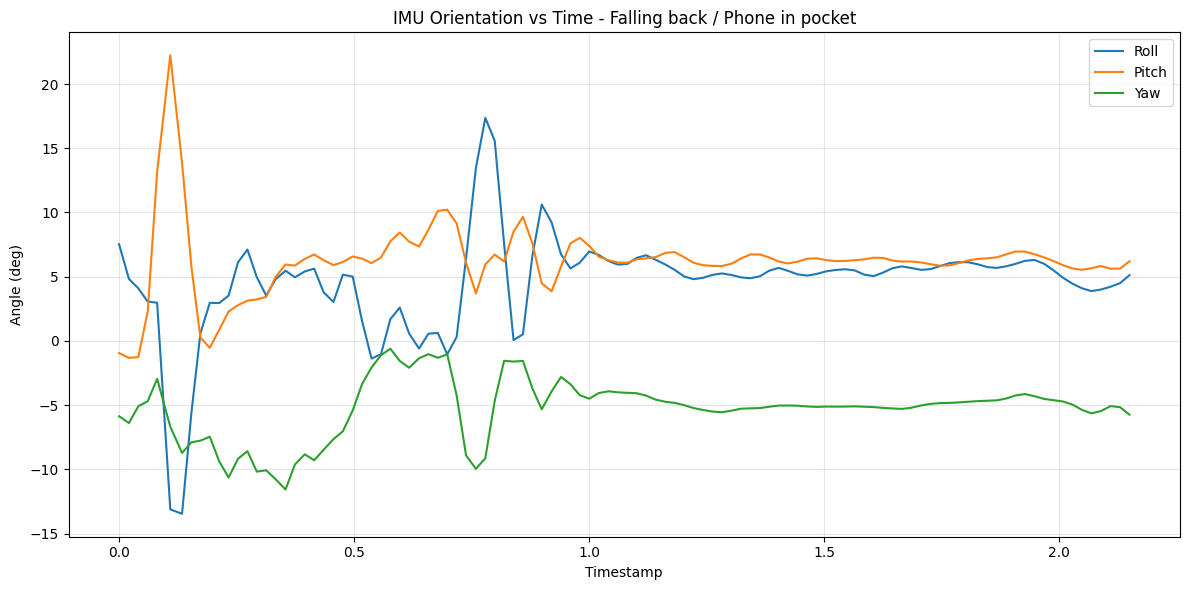

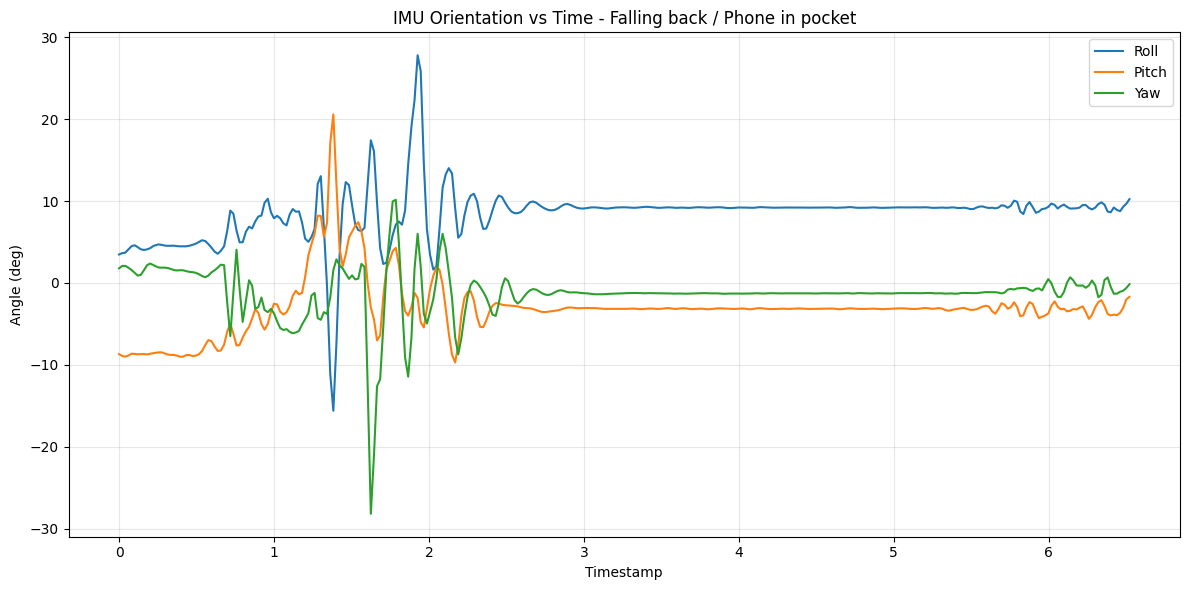

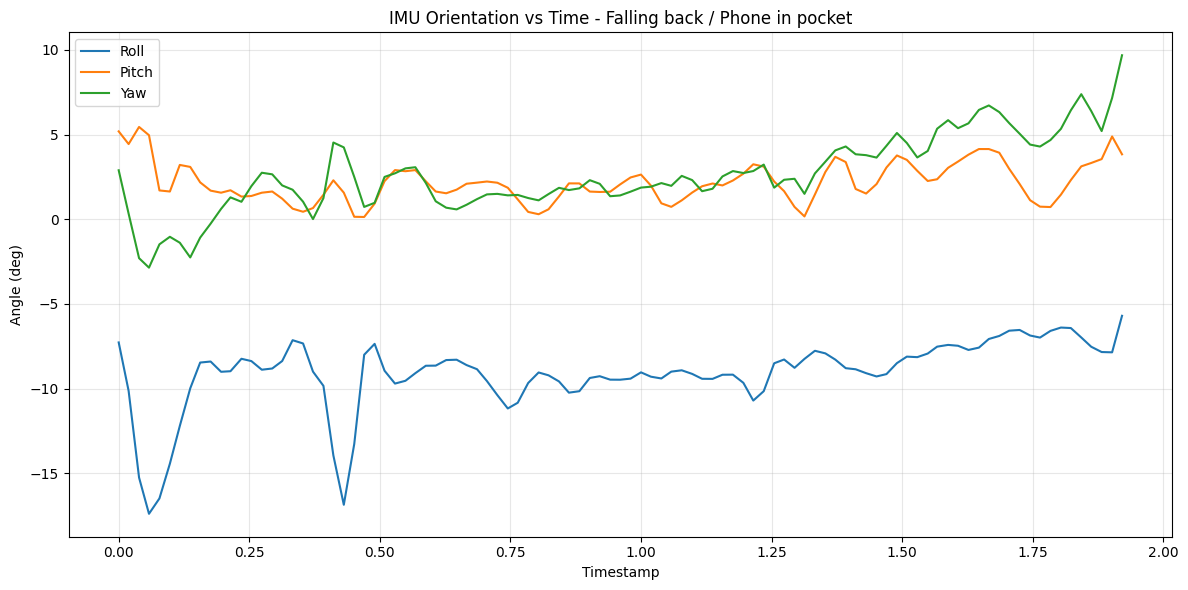

In [ ]:
# plotting falling back when phone in pocket
falling_back_pocket = dataset_path + '/falling_Back_Pocket'
falling_back_pocket_event_1 = falling_back_pocket + '/falling_back_pocket_1.csv'
falling_back_pocket_event_4 = falling_back_pocket + '/falling_back_pocket_4.csv'
falling_back_pocket_event_6 = falling_back_pocket + '/falling_back_pocket_6.csv'
subtitle = "Falling back / Phone in pocket"

plotgraph(falling_back_pocket_event_1)
plotgraph(falling_back_pocket_event_4)
plotgraph(falling_back_pocket_event_6)

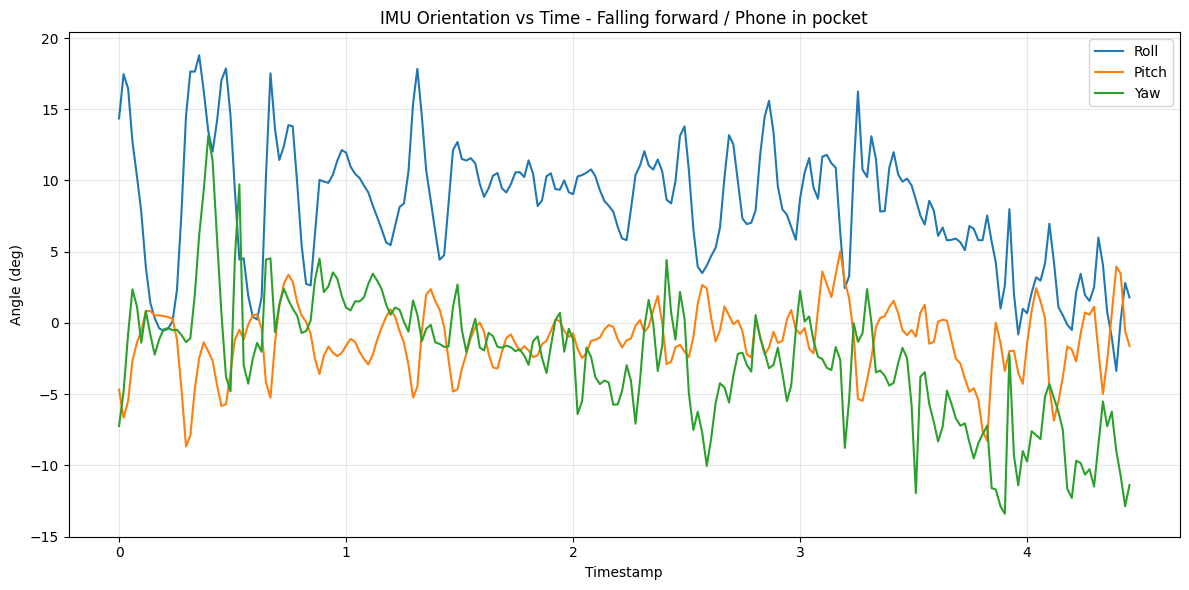

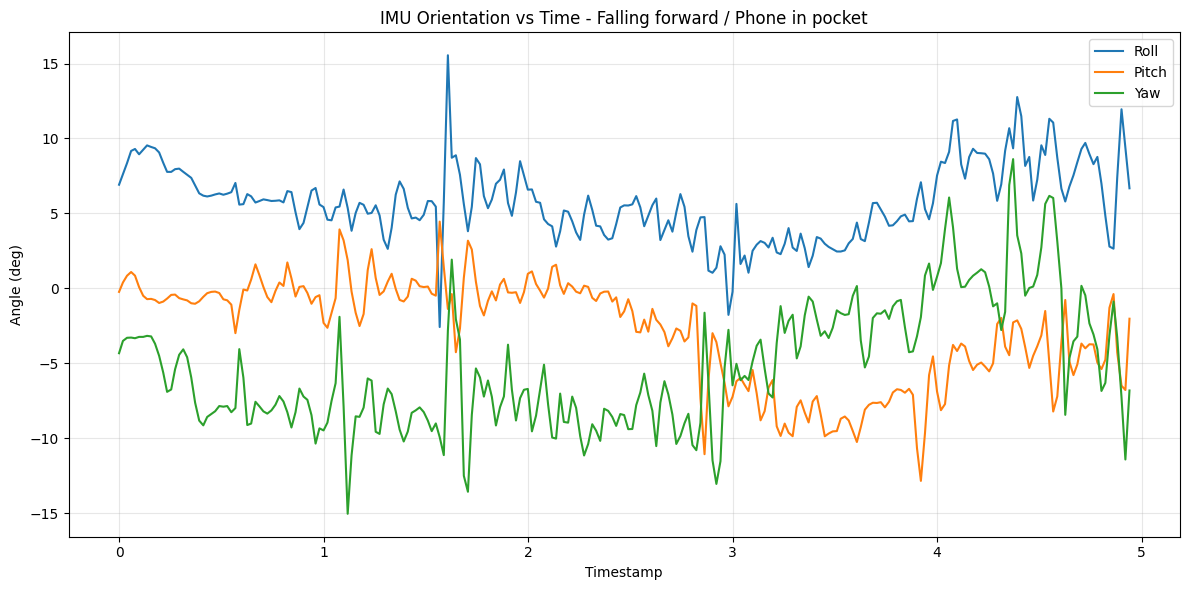

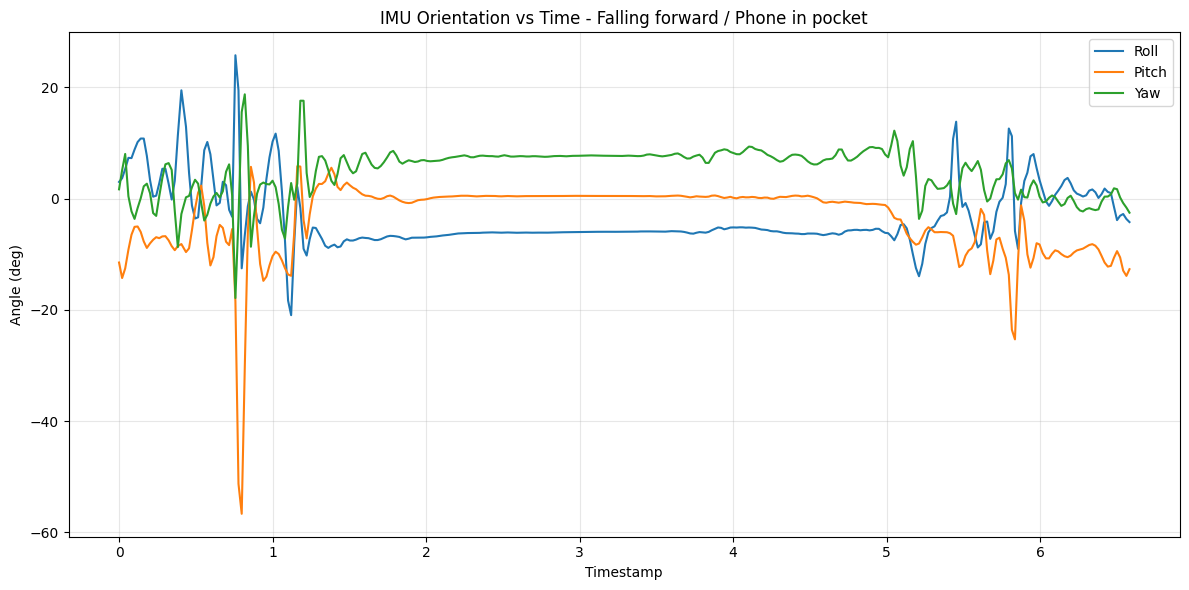

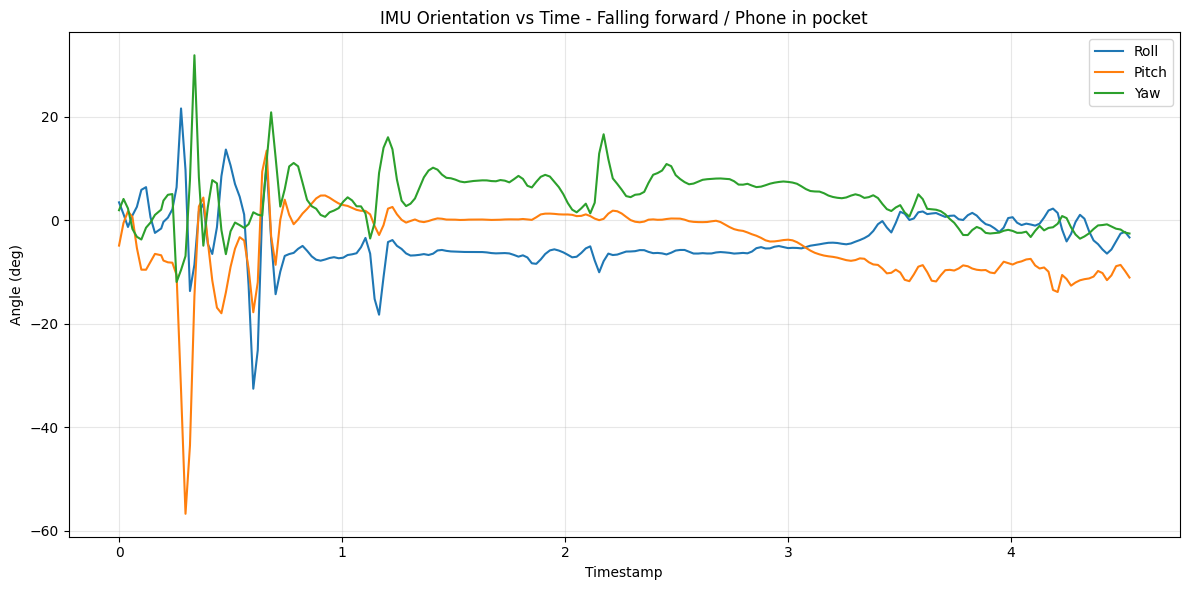

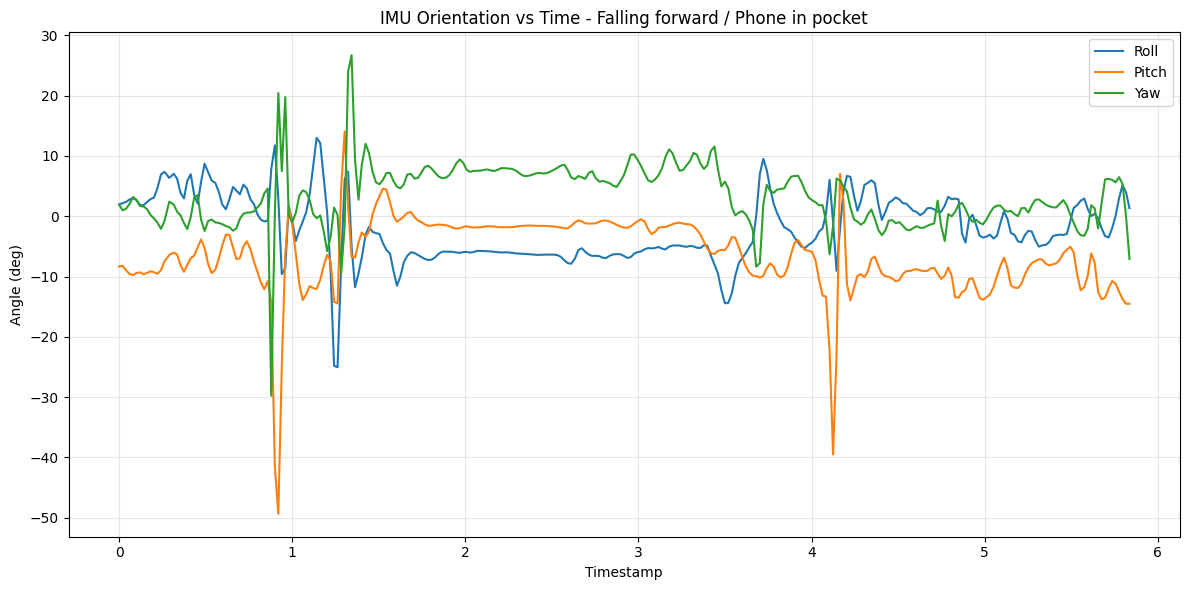

In [ ]:
# plotting falling forward events when phone is in pocket
falling_forward_pocket = dataset_path + '/falling_Forwad_Pocket'
falling_forward_pocket_event_1 = falling_forward_pocket + '/falling_forwad_pocket_1.csv'
falling_forward_pocket_event_2 = falling_forward_pocket + '/falling_forwad_pocket_2.csv'
falling_forward_pocket_event_3 = falling_forward_pocket + '/falling_forwad_pocket_3.csv'
falling_forward_pocket_event_4 = falling_forward_pocket + '/falling_forwad_pocket_4.csv'
falling_forward_pocket_event_5 = falling_forward_pocket + '/falling_forwad_pocket_5.csv'
subtitle = "Falling forward / Phone in pocket"

plotgraph(falling_forward_pocket_event_1)
plotgraph(falling_forward_pocket_event_2)
plotgraph(falling_forward_pocket_event_3)
plotgraph(falling_forward_pocket_event_4)
plotgraph(falling_forward_pocket_event_5)


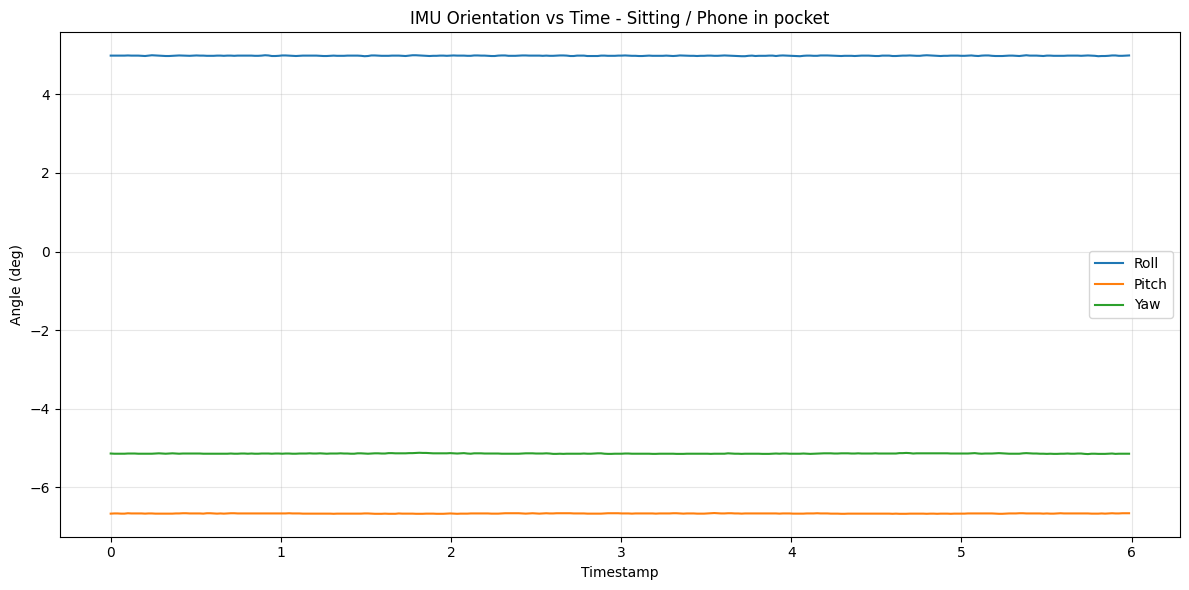

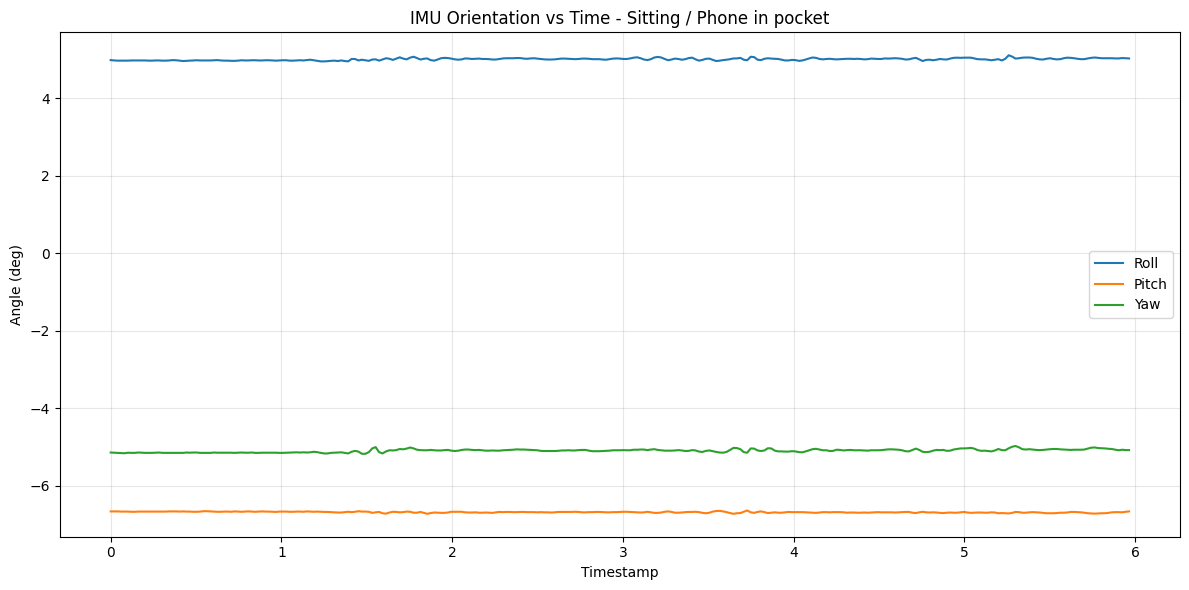

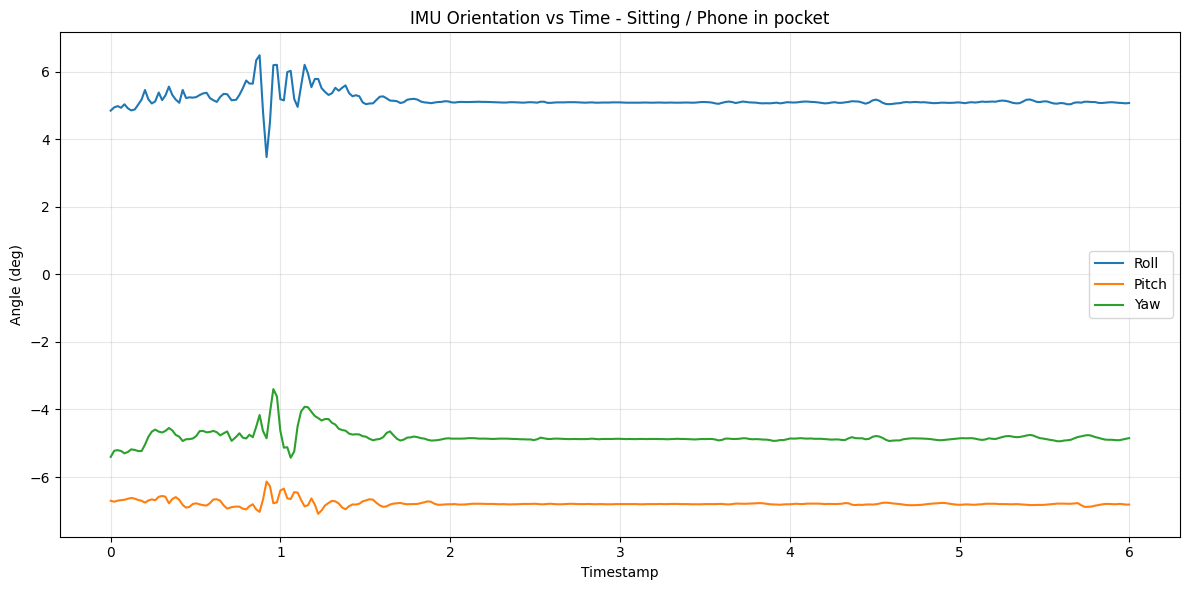

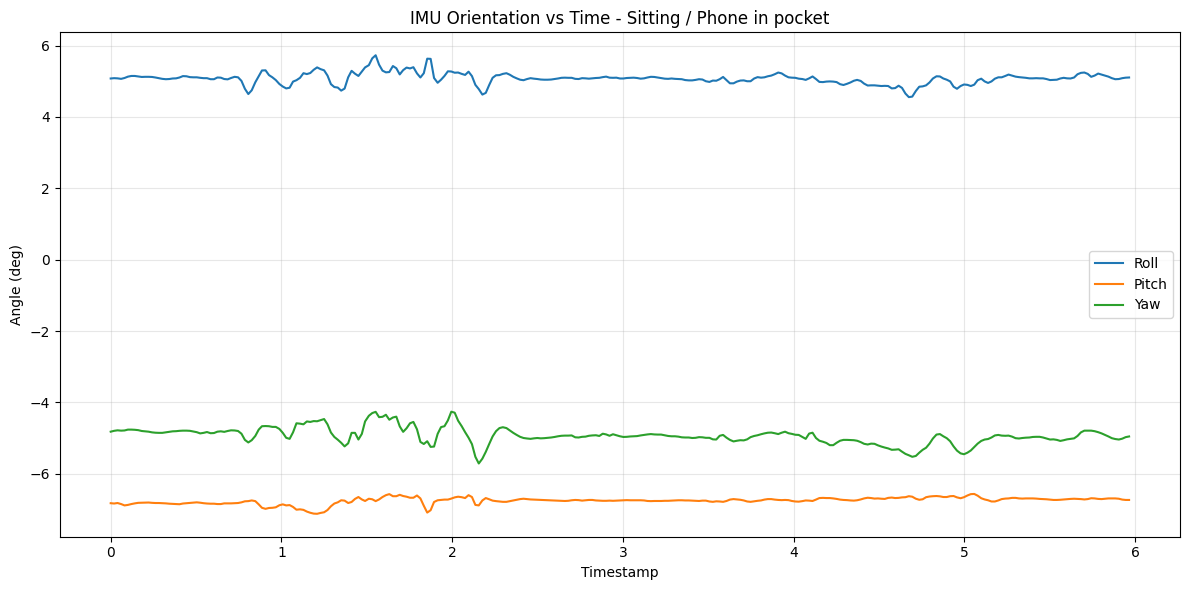

In [ ]:
# plotting sitting events when phone is in pocket
sitting_pocket = dataset_path + '/sitting_Pocket'
sitting_pocket_event_1 = sitting_pocket + '/sitting_pocket_100.csv'
sitting_pocket_event_2 = sitting_pocket + '/sitting_pocket_101.csv'
sitting_pocket_event_3 = sitting_pocket + '/sitting_pocket_51.csv'
sitting_pocket_event_4 = sitting_pocket + '/sitting_pocket_52.csv'
subtitle = "Sitting / Phone in pocket"

plotgraph(sitting_pocket_event_1)
plotgraph(sitting_pocket_event_2)
plotgraph(sitting_pocket_event_3)
plotgraph(sitting_pocket_event_4)


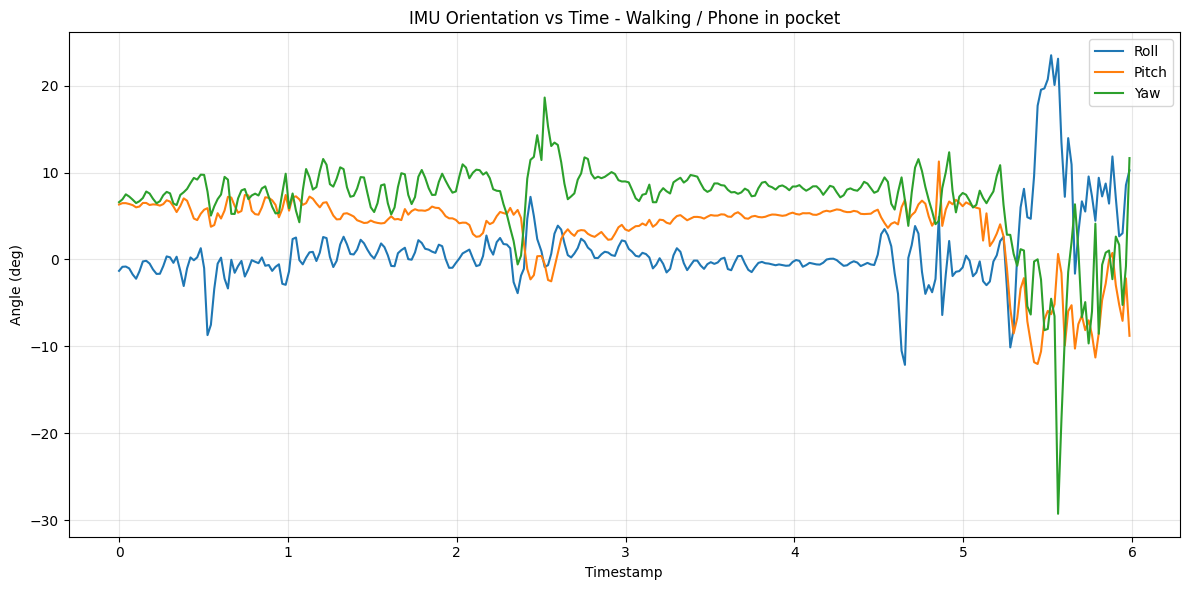

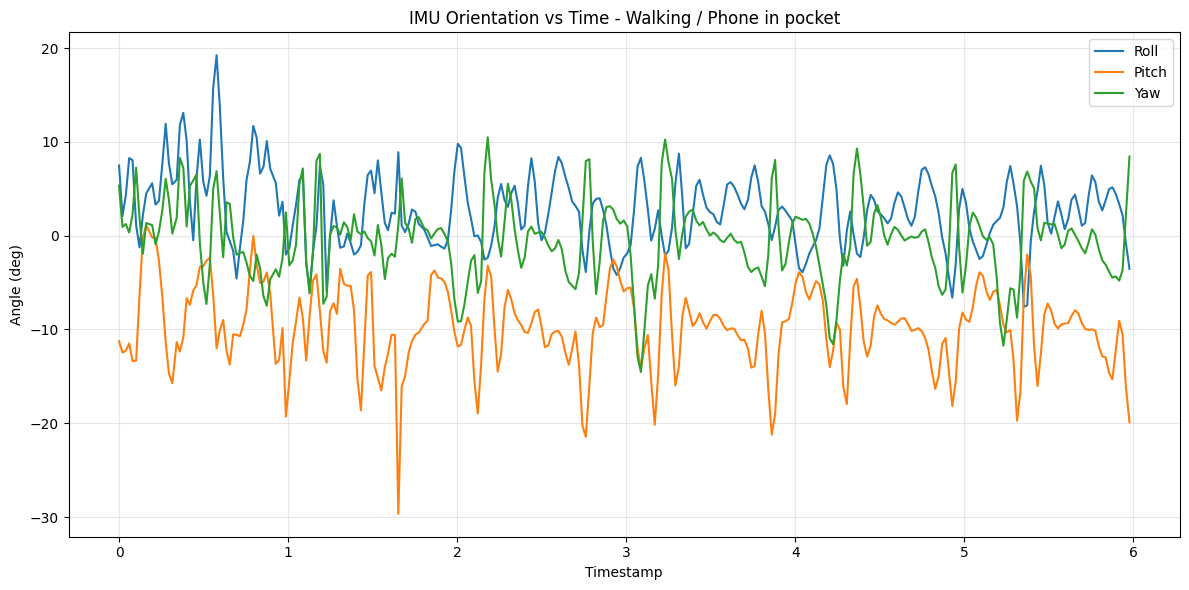

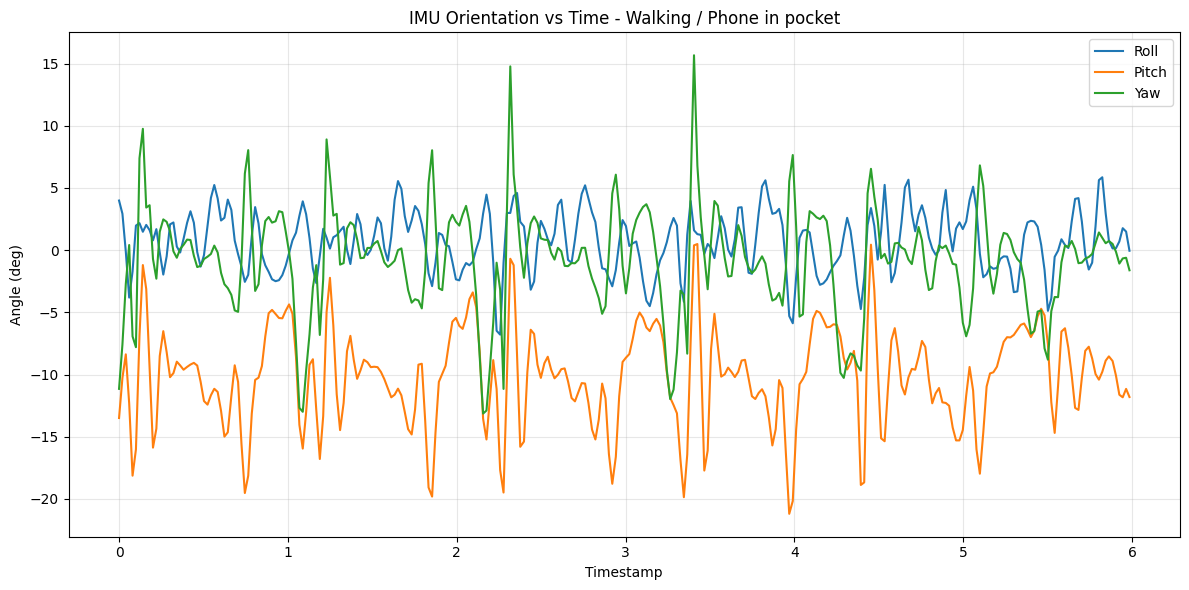

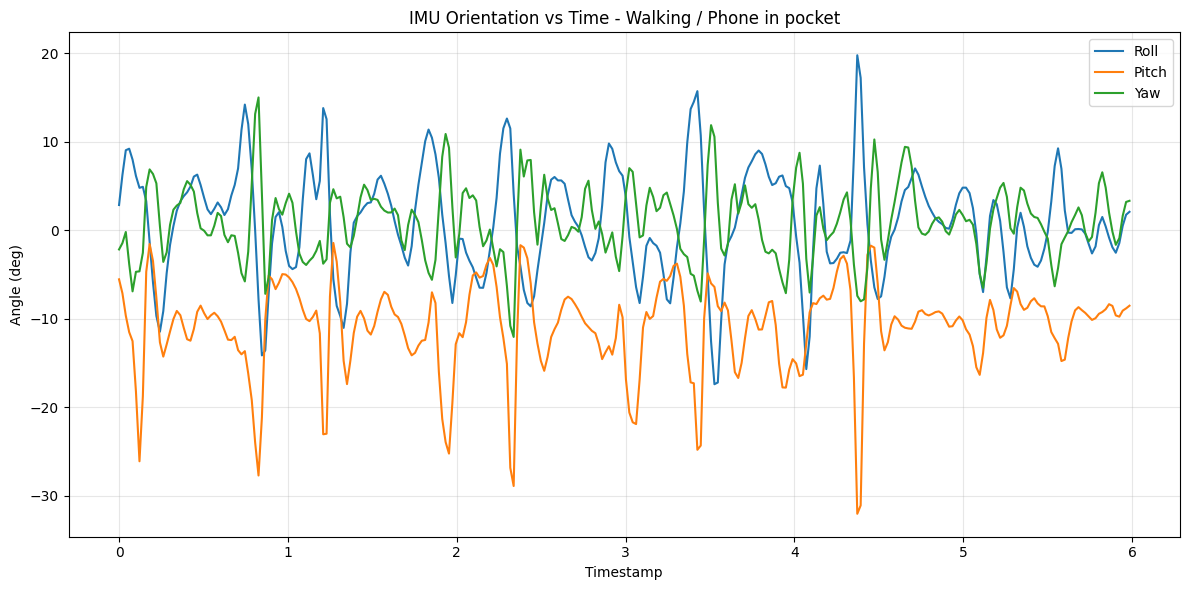

In [ ]:
# plotting walking events when phone is in pocket
walking_pocket = dataset_path + '/walking_Pocket'
walking_pocket_event_1 = walking_pocket + '/walking_pocket_151.csv'
walking_pocket_event_2 = walking_pocket + '/walking_pocket_152.csv'
walking_pocket_event_3 = walking_pocket + '/walking_pocket_153.csv'
walking_pocket_event_4 = walking_pocket + '/walking_pocket_154.csv'
subtitle = "Walking / Phone in pocket"

plotgraph(walking_pocket_event_1)
plotgraph(walking_pocket_event_2)
plotgraph(walking_pocket_event_3)
plotgraph(walking_pocket_event_4)

In [ ]:
def preprocessing_event(path, max_length=300, fall_event=False):
  """pad or truncate sequence to max_length"""
  df = pd.read_csv(path)
  df = df.rename(columns={
    'x': 'roll',
    'y': 'pitch',
    'z': 'yaw'
  })

  # Explicitly select only the required columns
  df = df[['timestamp', 'roll', 'pitch', 'yaw']]

  if(len(df) >= max_length):
    df = df.iloc[:max_length]
  # if less than max_length, repeat last couple entries
  else:
    pad_len = max_length - len(df)
    df = pd.concat([df, df.iloc[-pad_len:]], ignore_index=True)


  return np.array(df.iloc[0:max_length].values)

In [ ]:
test_event = dataset_path + '/falling_Right_Pocket/falling_right_pocket_10.csv'
a = preprocessing_event(test_event)
print(f"{a.shape=}, {a.dtype=}, {a.min()=}, {a.max()=}, {a.mean()=}")
a


a.shape=(300, 4), a.dtype=dtype('float64'), a.min()=np.float64(-63.608), a.max()=np.float64(15.06), a.mean()=np.float64(0.6605291666666665)


array([[ 0.   , -4.455, -9.105, -1.232],
       [ 0.019, -4.103, -8.932, -1.071],
       [ 0.038, -3.868, -8.875, -0.506],
       ...,
       [ 5.748, -4.728,  2.088,  8.44 ],
       [ 5.768, -4.972,  1.913,  8.416],
       [ 5.787, -4.999,  1.795,  8.363]])

In [ ]:
# next to do:
# - data integration: aggregate information from multiple files and label them
## - not fall: sitting_Pocket, sleeping_Pocket, walking_Pocket (10 samples)
## - fall: falling_Back_Pocket, falling_Forwad_Pocket, falling_Left_Pocket, falling_Right_Pocket
walking_pocket = dataset_path + '/walking_Pocket/*.csv'
sleeping_pocket = dataset_path + '/sleeping_Pocket/*.csv'
sitting_pocket = dataset_path + '/sitting_Pocket/*.csv'
falling_back_pocket = dataset_path + '/falling_Back_Pocket/*.csv'
falling_forward_pocket = dataset_path + '/falling_Forwad_Pocket/*.csv'
falling_left_pocket = dataset_path + '/falling_Left_Pocket/*.csv'
falling_right_pocket = dataset_path + '/falling_Right_Pocket/*.csv'
data = [
    walking_pocket,
    sleeping_pocket,
    sitting_pocket,
    falling_back_pocket,
    falling_forward_pocket,
    falling_left_pocket,
    falling_right_pocket
]

# datapoints containing too many errors
exceptions = [
    "falling_back_pocket_5.csv",
    "falling_back_pocket_6.csv",
    "falling_back_pocket_1.csv",
    "walking_pocket_209.csv",
    "falling_left_pocket_5.csv",
    "falling_forwad_pocket_18.csv"

]

# function to create our X, y data
def create_dataset(data, max_length=300):

  windows = []
  labels = []

  for group in data:
    for path in glob.glob(group):
      # Check if the file is in the exceptions list.
      if os.path.basename(path) in exceptions:
          continue
      window = preprocessing_event(path, max_length)
      # if window has less than max_length samples, throw it away
      if window.shape[0] < max_length:
        continue
      if group == walking_pocket or group == sleeping_pocket or group == sitting_pocket:
        print(f"processing NOT FALL events in: {path}")
        labels.append(0) # not fall
      else:
        print(f"processing FALL events in: {path}")
        labels.append(1) # fall
      print(f"{window.shape=}")
      windows.append(window)

  # Reshape the windows list into a 3D numpy array (samples, timesteps, features)
  result = np.array(windows)
  print(f"{result.shape=}, {result.dtype=}, {result.min()=}, {result.max()=}, {result.mean()=}")
  result_labels = np.array(labels)
  print(f"{result_labels.shape=}, {result_labels.dtype=}, {result_labels.min()=}, {result_labels.max()=}, {result_labels.mean()=}")

  return result, result_labels

In [ ]:
# create the windows from our data
X, y = create_dataset(data)

processing NOT FALL events in: /root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset/walking_Pocket/walking_pocket_270.csv
window.shape=(300, 4)
processing NOT FALL events in: /root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset/walking_Pocket/walking_pocket_193.csv
window.shape=(300, 4)
processing NOT FALL events in: /root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset/walking_Pocket/walking_pocket_192.csv
window.shape=(300, 4)
processing NOT FALL events in: /root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset/walking_Pocket/walking_pocket_172.csv
window.shape=(300, 4)
processing NOT FALL events in: /root/.cache/kagglehub/datasets/felliphnascimento/accelerometer-falling-detection/versions/6/Dataset/walking_Pocket/walking_pocket_217.csv
window.shape=(300, 4)
processing NOT FALL events in: /root/.ca

In [ ]:
# split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize/scale the features

from sklearn.preprocessing import StandardScaler

# reshape for scaling
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to (samples, timesteps, features)
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

# Now X_train and X_test have shape (n_samples, 300, 4)
# where 4 represents [timestamp, roll, pitch, yaw]


In [ ]:

# CNN-LSTM model for capturing both spatial and temporal patterns
def create_cnn_lstm_model(input_shape):
    model = keras.Sequential([
        # Convolutional layers to extract features
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),

        # LSTM layer to capture temporal dependencies
        layers.LSTM(64, return_sequences=False),

        # Dense layers for classification
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification (fall vs. non-fall)
    ])

    return model

In [ ]:
# create and compile the model
input_shape = (X_train.shape[1], X_train.shape[2]) # (300,4)
model = create_cnn_lstm_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.7518 - loss: 0.5907 - val_accuracy: 0.8367 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8395 - loss: 0.3322 - val_accuracy: 0.8776 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9215 - loss: 0.2210 - val_accuracy: 0.9592 - val_loss: 0.1433 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9757 - loss: 0.1493 - val_accuracy: 0.9796 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9718 - loss: 0.1547 - val_accuracy: 1.0000 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9720 - loss: 0.1640 - val_accuracy: 0.9796 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9592 - loss: 0.1422 - val_accuracy: 1.0

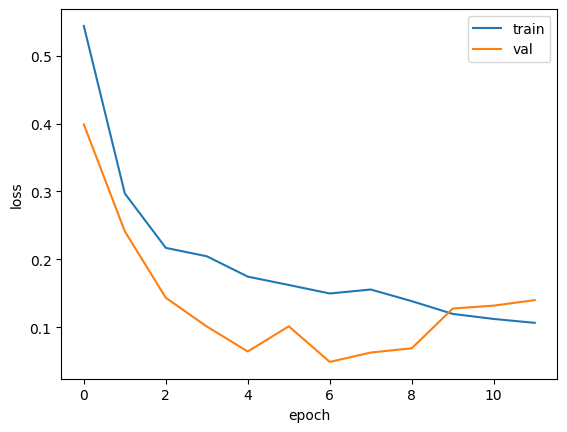

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

In [ ]:
# saving the model
model.save("model.keras")

In [ ]:
# convert to tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpkw83u34e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137083816063248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816064016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816065552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816065360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816065744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816064976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816066512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816066704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816066320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816065936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137083816064784: Te

In [ ]:
import os
model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % model_size)

Model is 529420 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 3,264,792 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
# test event
path = "/kaggle/input/accelerometer-falling-detection/Dataset/falling_Forwad_Pocket/falling_forwad_pocket_20.csv"
fall_event = preprocessing_event(path)
print(fall_event.shape)

prediction = model.predict(np.array([fall_event]))
print(prediction)


# not fall event
not_fall_event = preprocessing_event(sitting_pocket_event_1)
print(not_fall_event.shape)

prediction = model.predict(np.array([not_fall_event]))
print(prediction)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/accelerometer-falling-detection/Dataset/falling_Forwad_Pocket/falling_forwad_pocket_20.csv'

In [ ]:
from testing import Tester

tester = Tester(predictor=model, data=X_test, labels=y_test, title=type(model).__name__, size=100)
tester.run()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
 Guess: [[0.06602108]] True: 0 Error: [0.06602108]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
 Guess: [[0.07604674]] True: 0 Error: [0.07604674]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
 Guess: [[0.01907771]] True: 0 Error: [0.01907771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
 Guess: [[0.07511926]] True: 0 Error: [0.07511926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
 Guess: [[0.02161474]] True: 0 Error: [0.02161474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
 Guess: [[0.02362072]] True: 0 Error: [0.02362072]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
 Guess: [[0.01586486]] True: 0 Error: [0.01586486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
 Guess: [[0.04857653]] True: 0 Error: [0.04857653]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
 Guess: [[0.04872636]] True: 0 Error: [0.04872636]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
 Guess: [[0.0191413]] True: 0 Error: [0.0191413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
 Guess: [[0.01751806]] True: 0 Error: [0.01751806]
1/1 ━━━━━━━━━━━━━

IndexError: index 62 is out of bounds for axis 0 with size 62